Episode 1: Failure - Steps: 3866 - Explore: 156 - Exploit: 3710
Episode 2: Success - Steps: 2452 - Explore: 91 - Exploit: 2361
Episode 3: Success - Steps: 7488 - Explore: 306 - Exploit: 7182
Episode 4: Max steps reached - Steps: 20000 - Explore: 782 - Exploit: 19218
Episode 5: Failure - Steps: 5176 - Explore: 234 - Exploit: 4942
Episode 6: Failure - Steps: 6967 - Explore: 248 - Exploit: 6719
Episode 7: Failure - Steps: 10212 - Explore: 405 - Exploit: 9807
Episode 8: Failure - Steps: 3517 - Explore: 131 - Exploit: 3386
Episode 9: Success - Steps: 3676 - Explore: 138 - Exploit: 3538
Episode 10: Success - Steps: 4892 - Explore: 195 - Exploit: 4697
       Run  Episode  Step  Position  Velocity      Gradient     Color  Action  \
0       10        1     1 -0.524599 -0.001000  6.123234e-17  Colour 1      -1   
1       10        1     2 -0.524591  0.000007 -2.999996e-03  Colour 1       1   
2       10        1     3 -0.525576 -0.000985 -2.977496e-03  Colour 1      -1   
3       10        1    

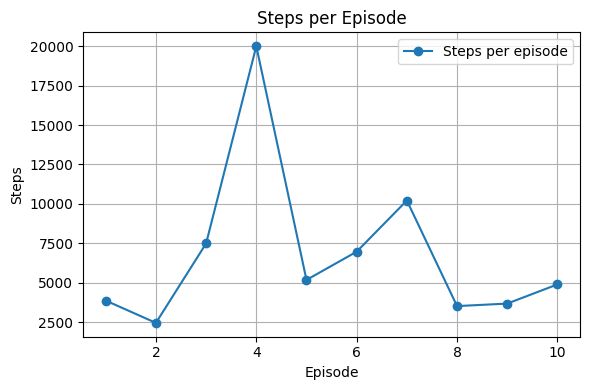

In [14]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Constants
min_position = -1.5
max_position = 1.8
goal_position_hill = math.pi / 6
goal_position_valley = 3 * math.pi / 6 
force = 0.001
gravity = 0.0025
max_speed = 0.07
start_position = -math.pi / 6
hill_frequency = 3

min_gradient = np.cos(3 * max_position)
max_gradient = np.cos(3 * min_position)

x_threshold = 0.0 #chose 0.0 because the position is in -0.5 and the goal is around 1.5, tried with different thresholds and this was better.
deceleration_threshold = 0.06  #threshold distance in meters to start decelerating
deceleration_factor = 0.1

def hill(x):
    return np.sin(hill_frequency * x) * 0.5

num_steps = 20000
episodes = 10
gradient_bins = 60
action_space = [-1, 1]

# Q learning parameters
alpha = 0.1
gamma = 0.99
epsilon = 0.04
epsilon_decay = 0.995
epsilon_min = 0.002
runs = 0


#Bins for discretising the continous space
gradient_bin_edges = np.linspace(min_gradient, max_gradient, gradient_bins)

# Q table initialisation with colours (4 Colours)
Q = np.zeros((len(gradient_bin_edges), 4, len(action_space)))  # (gradient_bins, 5 colors, actions)

#function to get the colour if the agent is in a particular position
def get_colour(position):
    if position <= -0.5:
        return 0  #colour 1 or light green
    elif position <= -0.3 and position > -0.5:
        return 1  #colour 2 or green
        
    elif position <= 0.0 and position > -0.3:
        return 2 #colour 3 or light red
    else:
        return 3 #colour 4 or red


#data collection for debugging 
data = []
steps_per_episode = []
total_rewards_per_episode = []
deceleration_threshold = 0.06  #threshold distance in meters to start decelerating
deceleration_factor = 0.1

def run_ep(episode_num, epsilon):
    steps_in_episode = 0
    xplore_no = 0
    exp_no = 0
    data_episode = []
    success = 0

    position = start_position
    velocity = 0.0
    done = False

    while not done:
        gradient = np.cos(3 * position)
         #discretise the position state but with gradient as the agent is unaware of it, carrying on from task 3
        state_g = np.digitize(gradient, gradient_bin_edges) - 1
        colour = get_colour(position) #gets the colour for that position

           #choosing an action, explore of exploit
        if np.random.rand() < epsilon:
            action_index = np.random.choice(len(action_space)) #exploring
            xplore_no += 1
        else:
            action_index = np.argmax(Q[state_g, colour]) #exploiting
            exp_no += 1

        action = action_space[action_index]


         #Physics stuff to  move the car
        applied_force = action * force
        velocity += applied_force - gravity * gradient
        velocity = np.clip(velocity, -max_speed, max_speed)
        position += velocity
        position = np.clip(position, min_position, max_position)


         #the reward logic
        reward = 10.0 if abs(position - goal_position_valley) < 0.01 else -0.01
        if position <= min_position:
            reward = -5.0

#some more reward so that the agent would behave, increased it so that the agent could learn and go towards the goal, guiding the agent
            
        if action_index > 0 and colour == 3: #increased number of colours = increased complexity = more learning time/exploring, rewards make the agent behave
            reward += 0.1

        if action_index > 0 and colour == 2: #lower additional reward so that the agent knows it's on the right path but could do better
            reward += 0.01



        data.append({
            'Episode': episode_num + 1,
            "Step": steps_in_episode + 1,
            "Position": position,
            "Velocity": velocity,
            "Gradient": gradient,
            "Color": "Colour " + str(colour + 1),  # Updated to show the color number
            "Action": action,
            "Reward": reward,
            "Q-value": Q[state_g, colour, action_index]
        })

         #update the gradient
        new_gradient = np.cos(3 * position)
        new_state =np.digitize(new_gradient, gradient_bin_edges) - 1
        new_colour = get_colour(position)

           #update Q learning
        best_future_q = np.max(Q[new_state, new_colour])
        Q[state_g, colour, action_index] += alpha * (reward + gamma * best_future_q - Q[state_g, colour, action_index])

       
        distance_to_goal = abs(position - goal_position_valley)

        #deceleration logic: slow down more as the agent approaches the goal
        if distance_to_goal <= deceleration_threshold: #when it's within the given threshold
            #reduce the velocity as the agent gets closer to the goal
            velocity *= (1 - deceleration_factor)  # Apply deceleration factor

        #clipping velocity to prevent overshooting type of behaviour
        velocity = np.clip(velocity, -max_speed, 0.06)

        steps_in_episode += 1

        if abs(position - goal_position_valley) < 0.01 and abs(velocity) < 0.07:
            outcome = "Success"
            success += 1
            done = True
        elif position <= min_position:
            outcome = "Failure"
            done = True
        elif steps_in_episode == num_steps:
            outcome = "Max steps reached"
            done = True
    print(f"Episode {episode_num + 1}: {outcome} - Steps: {steps_in_episode} - Explore: {xplore_no} - Exploit: {exp_no}")
    return data_episode, steps_in_episode
    

#run the episodes
for episode in range(episodes):
    episode_data, steps = run_ep(episode, epsilon)
    data.extend(episode_data)
    steps_per_episode.append(steps)
    epsilon = max(epsilon * epsilon_decay, epsilon_min)  #exponential decay
    
#convert the data into dataframe for viewing
df = pd.DataFrame(data)
print(df)

#plotting steps per episode for all 10 episodes
plt.figure(figsize=(6, 4))
plt.plot(range(1, episodes + 1), steps_per_episode, marker="o", label="Steps per episode")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Steps per Episode")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Success in run 1: 5, steps: 73463
Success in run 2: 9, steps: 27691
Success in run 3: 8, steps: 48919
Success in run 4: 7, steps: 43405
Success in run 5: 7, steps: 38436
Success in run 6: 8, steps: 42631
Success in run 7: 8, steps: 29915
Success in run 8: 8, steps: 24046
Success in run 9: 6, steps: 72688
Success in run 10: 6, steps: 90216
Total success:  72
Average step run:  49141.0
[1963.4 2708.5 4379.2 4405.3 5271.3 5748.2 6013.6 6092.2 7504.5 5054.8]


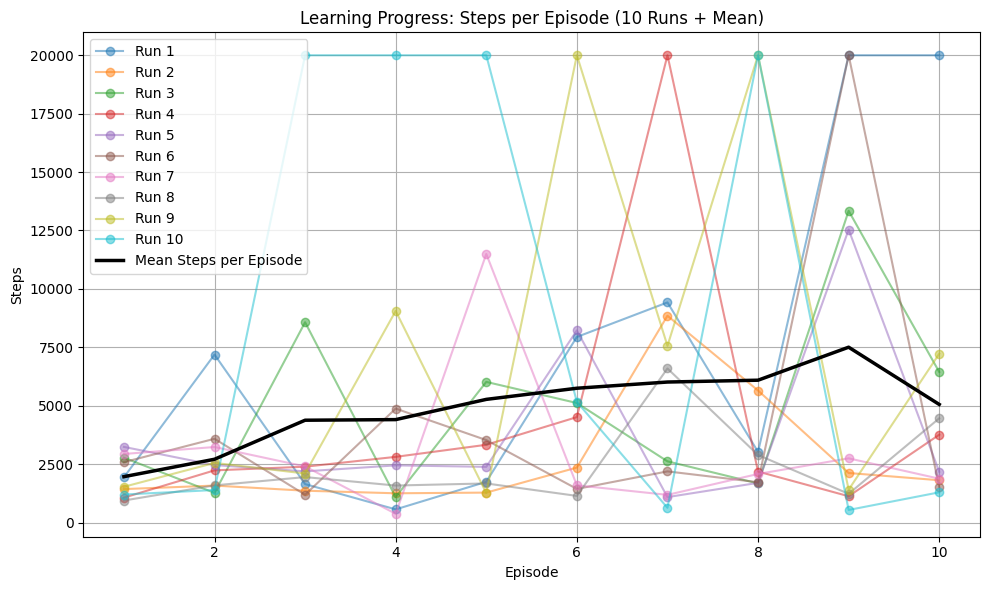

        Run  Episode  Step  Position  Velocity      Gradient     Color  \
0         1        1     1 -0.524599 -0.001000  6.123234e-17  Colour 1   
1         1        1     2 -0.524591  0.000007 -2.999996e-03  Colour 1   
2         1        1     3 -0.525576 -0.000985 -2.977496e-03  Colour 1   
3         1        1     4 -0.525547  0.000030 -5.932634e-03  Colour 1   
4         1        1     5 -0.526502 -0.000956 -5.843310e-03  Colour 1   
...     ...      ...   ...       ...       ...           ...       ...   
491405   10       10  1289  1.332082  0.062966 -7.864503e-01  Colour 4   
491406   10       10  1290  1.394723  0.062641 -6.564796e-01  Colour 4   
491407   10       10  1291  1.456983  0.062260 -5.039957e-01  Colour 4   
491408   10       10  1292  1.518820  0.061837 -3.348432e-01  Colour 4   
491409   10       10  1293  1.575862  0.057042 -1.552964e-01  Colour 4   

        Action  Reward   Q-value  
0           -1   -0.01  0.000000  
1            1   -0.01  0.000000  
2     

In [13]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt

# Constants
min_position = -1.5
max_position = 1.8
goal_position_hill = math.pi / 6
goal_position_valley = 3 * math.pi / 6 
force = 0.001
gravity = 0.0025
max_speed = 0.07
start_position = -math.pi / 6
hill_frequency = 3

min_gradient = np.cos(3 * max_position)
max_gradient = np.cos(3 * min_position)

x_threshold = 0.0 #chose 0.0 because the position is in -0.5 and the goal is around 1.5, tried with different thresholds and this was better.
deceleration_threshold = 0.06  #threshold distance in meters to start decelerating
deceleration_factor = 0.1

def hill(x):
    return np.sin(hill_frequency * x) * 0.5

num_steps = 20000
episodes = 10
gradient_bins = 60
action_space = [-1, 1]

# Q learning parameters
alpha = 0.1
gamma = 0.99
epsilon = 0.04
epsilon_decay = 0.995
epsilon_min = 0.002
runs = 0


#Bins for discretising the continous space
gradient_bin_edges = np.linspace(min_gradient, max_gradient, gradient_bins)

# Q table initialisation with colours (4 Colours)
Q = np.zeros((len(gradient_bin_edges), 4, len(action_space)))  

#function to get the colour if the agent is in a particular position
def get_colour(position):
    if position <= -0.5:
        return 0  #colour 1 or light green
    elif position <= -0.3 and position > -0.5:
        return 1  #colour 2 or green
        
    elif position <= 0.0 and position > -0.3:
        return 2 #colour 3 or light red
    else:
        return 3 #colour 4 or red


#data collection for debugging 
data = []
steps_per_episode = []
total_rewards_per_episode = []
deceleration_threshold = 0.06  #threshold distance in meters to start decelerating
deceleration_factor = 0.1

def run_ep(episode_num, epsilon):
    steps_in_episode = 0
    xplore_no = 0
    exp_no = 0
    data_episode = []
    success = 0

    position = start_position
    velocity = 0.0
    done = False

    while not done:
        gradient = np.cos(3 * position)
         #discretise the position state but with gradient as the agent is unaware of it, carrying on from task 3
        state_g = np.digitize(gradient, gradient_bin_edges) - 1
        colour = get_colour(position) #gets the colour for that position

           #choosing an action, explore of exploit
        if np.random.rand() < epsilon:
            action_index = np.random.choice(len(action_space)) #exploring
            xplore_no += 1
        else:
            action_index = np.argmax(Q[state_g, colour]) #exploiting
            exp_no += 1

        action = action_space[action_index]


         #Physics stuff to  move the car
        applied_force = action * force
        velocity += applied_force - gravity * gradient
        velocity = np.clip(velocity, -max_speed, max_speed)
        position += velocity
        position = np.clip(position, min_position, max_position)


         #the reward logic
        reward = 10.0 if abs(position - goal_position_valley) < 0.01 else -0.01
        if position <= min_position:
            reward = -5.0

#some more reward so that the agent would behave, increased it so that the agent could learn and go towards the goal, guiding the agent
            
        if action_index > 0 and colour == 3: #increased number of colours = increased complexity = more learning time/exploring, rewards make the agent behave
            reward += 0.1

        if action_index > 0 and colour == 2: #lower additional reward so that the agent knows it's on the right path but could do better
            reward += 0.01


    #recording data
        data.append({
            "Run": run + 1,
            'Episode': episode_num + 1,
            "Step": steps_in_episode + 1,
            "Position": position,
            "Velocity": velocity,
            "Gradient": gradient,
            "Color": "Colour " + str(colour + 1),  # Updated to show the color number
            "Action": action,
            "Reward": reward,
            "Q-value": Q[state_g, colour, action_index]
        })

         #update the gradient
        new_gradient = np.cos(3 * position)
        new_state =np.digitize(new_gradient, gradient_bin_edges) - 1
        new_colour = get_colour(position)

           #update Q learning
        best_future_q = np.max(Q[new_state, new_colour])
        Q[state_g, colour, action_index] += alpha * (reward + gamma * best_future_q - Q[state_g, colour, action_index])

       
        distance_to_goal = abs(position - goal_position_valley)

        #deceleration logic: slow down more as the agent approaches the goal
        if distance_to_goal <= deceleration_threshold: #when it's within the given threshold
            #reduce the velocity as the agent gets closer to the goal
            velocity *= (1 - deceleration_factor)  # Apply deceleration factor

        #clipping velocity to prevent overshooting type of behaviour
        velocity = np.clip(velocity, -max_speed, 0.06)

        steps_in_episode += 1

        if abs(position - goal_position_valley) < 0.01 and abs(velocity) < 0.07:
            outcome = "Success"
            success += 1
            done = True
        elif position <= min_position:
            outcome = "Failure"
            done = True
        elif steps_in_episode == num_steps:
            outcome = "Max steps reached"
            done = True
    #Uncomment this to see the runs in more detail
    #print(f'Run {run + 1} Episode {episode_num + 1}: {outcome} - Steps: {steps_in_episode} - Explore: {xplore_no} - Exploit: {exp_no}')
    return steps_in_episode, success

#Data for plotting for all 10 runs with 10 episodes
steps_per_run = []
total_success = 0
total_run_steps = 0  #to calculate total steps from all runs
for run in range(10): 
    Q = np.zeros((len(gradient_bin_edges), 4,  len(action_space)))
    steps_per_episode = []
    success_per_ep = 0 # successful outcomes per episode
    success_per_run =0  # successful outcomes per run, its data will be used for finding the sum of overall successful outcomes to measure performance
    epsilon = 0.04 # resetting epsilon for each run
    steps_one_run = 0  #collects steps for one run, its data will be used for calculating the average of all runs
    
    for episode in range(episodes):         
        steps, success_no = run_ep(episode, epsilon)        
        steps_per_episode.append(steps)
        success_per_ep += success_no
        steps_one_run += steps
        epsilon = max(epsilon * epsilon_decay, epsilon_min)   #exponential decay per episode

    steps_per_run.append(steps_per_episode)
    success_per_run += success_per_ep #successful outcomes per run
    total_success += success_per_run # total successful outcomes 
    total_run_steps += steps_one_run #total steps from all runs
    print(f"Success in run {run + 1}: {success_per_run}, steps: {steps_one_run}")  #shows all successful outcomes in each run along with steps for each run

average_steps_per_run = total_run_steps / 10  # average steps per run to check performance

#printing data for performance
print("Total success: ", total_success) #shows the sum of all successful outcomes of all 10 runs
print("Average step run: ", average_steps_per_run)


#Calculate the mean steps per episode across all runs
mean_steps = np.mean(steps_per_run, axis=0)
print(mean_steps)


#Plotting all 10 runs and 10 episodes
plt.figure(figsize=(10, 6))
for run_idx, steps in enumerate(steps_per_run):
    plt.plot(range(1, episodes + 1), steps, marker="o", label=f"Run {run_idx + 1}", alpha=0.5)

plt.plot(range(1, episodes + 1), mean_steps, color="black", linewidth=2.5, label="Mean Steps per Episode")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Steps per episode for all 10 runs with mean")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#printing the dataframe
df = pd.DataFrame(data)
print(df)
